# Important information about this EDA, (Exploratory Data Analysis)
Exploring the files in the 'data/processed/' directory<br>

**Please note:** The analysis will be divided into four distinct sections, each addressing different files, as outlined below::
- App usage in the phone, (Files: 'app_usage_count_motorola.csv' and 'app_usage_time_motorola.csv')
- Device unlocks analysis, (Files: 'device_unlocks_motorola.csv')
- Web usage count, (Files: 'web_usage_count_chrome.csv', 'web_usage_count_edge.csv', 'web_usage_count_motorola.csv')
- Web usage time, (Files: 'web_usage_time_chrome.csv', 'web_usage_time_edge.csv', 'web_usage_time_motorola.csv')

*App usage time* and *Web usage time* files have every column except the date to be in minutes.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

sns.set_theme(style="whitegrid")

Connection to the sql server database

In [29]:
def read_from_sql_database(server, database, username, password, driver, queries):
    # Creating the SQLAlchemy connection
    connection_string = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver}"
    engine = create_engine(connection_string)
    dataframes = {}
    for query in queries:
        dataframes[query.split()[-1]] = pd.read_sql(query, engine, parse_dates=['date'])
        
    return dataframes

# Connection parameters
server = 'DESKTOP-8PK64UI'
database = 'statistics_of_use_db'
username = 'main_estiven'
driver = 'ODBC+Driver+17+for+SQL+Server'

password_file_path = "database_pass.txt"
with open(password_file_path, "r") as file:
    password = file.read().strip()

Reading the files for App usage in the phone

In [30]:
sql_queries = ["SELECT * FROM app_usage_count_motorola", "SELECT * FROM app_usage_time_motorola", 
               "SELECT * FROM web_usage_time_edge", "SELECT * FROM device_unlocks_motorola"]
result_df = read_from_sql_database(server, database, username, password, driver, sql_queries)

app_count_motorola = result_df['app_usage_count_motorola']
app_time_motorola = result_df['app_usage_time_motorola']
web_time_edge = result_df['web_usage_time_edge']
device_unlocks = result_df['device_unlocks_motorola']

count_columns = list(app_count_motorola.columns)
time_columns = list(app_time_motorola.columns)

# Exploratory Data Analysis

## App usage in the phone

Overview of the datasets

In [31]:
print(f'App count motorola:\n{app_count_motorola.head(1)}\n')
print(f'App count motorola:\n{app_time_motorola.head(1)}\n')
print(f'Web time edge:\n{web_time_edge.head(1)}\n')
print(f'Device unlocks:\n{device_unlocks.head(1)}\n')

App count motorola:
        date  amazon_shopping  android_system  calculator  calendar  camera  chrome  classroom  clock  discord  drive  files  gmail  google  google_news  google_opinion_rewards  google_play_services  google_play_store  instagram  linkedin  maps  medium  mi_tigo  microsoft_365_(office)  moto_app_launcher  nequi_colombia  notion  package_installer  photomath  photos  settings  siata  simcity  spotify  stellarium  symbolab  system_ui  tasks  teams  telegram  tiktok  truecaller  twitter  tyba  upwork_talent  whatsapp  youtube  youtube_music  zoom  total_usage  apple_music  didi  freelancer  money_manager  paypal  sleepy  call_of_duty  chatgpt  cívica  clash_of_clans  hbo_max  rappi
0 2022-10-19              0.0             1.0         5.0       3.0     0.0    24.0        5.0    8.0      0.0   11.0    2.0    4.0     0.0          4.0                     2.0                   1.0                0.0       33.0       0.0   0.0     0.0      0.0                     0.0        

In [32]:
print(f'Shape of the motorola time usage dataframe, (ORIGINAL): {app_time_motorola.shape}\n\
Shape of the motorola count usage dataframe, (ORIGINAL): {app_count_motorola.shape}\n\
Shape of the edge time usage dataframe, (ORIGINAL): {web_time_edge.shape}\n\
Shape of the motorola unlocks dataframe, (ORIGINAL): {device_unlocks.shape}\n')

Shape of the motorola time usage dataframe, (ORIGINAL): (552, 52)
Shape of the motorola count usage dataframe, (ORIGINAL): (552, 62)
Shape of the edge time usage dataframe, (ORIGINAL): (330, 39)
Shape of the motorola unlocks dataframe, (ORIGINAL): (552, 2)



## Data transformation and cleaning

In [33]:
def percentage_of_zeros(dataframe: pd.DataFrame, dataframe_column: str) -> float:
    """
    Calculate the percentage of zero values in a specific column of a pandas DataFrame.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing the data.
    dataframe_column (str): The column name for which the percentage of zero values should be calculated.

    Returns:
    float: The percentage of zero values in the specified column, rounded to two decimal places.

    Example:
    >>> import pandas as pd
    >>> data = {'column_A': [0, 0, 3, 0, 5, 0, 0]}
    >>> df = pd.DataFrame(data)
    >>> percentage = percentage_of_zeros(df, 'column_A')
    >>> print(percentage)
    71.43
    """
    percentage_zeros = (dataframe[dataframe_column] == 0).astype(int).sum(axis=0) / dataframe.shape[0]
    return round(percentage_zeros * 100, 2)

Filtering the data so there are not too much zeros, if the column has more than 70% of zeros, it will be eliminated

In [34]:
def remove_zero_columns(df, threshold):
    """
    This function removes columns from a DataFrame that have a percentage of zeros greater than a specified threshold.

    Parameters:
    df (pandas.DataFrame): The DataFrame to process.
    threshold (float): The percentage threshold for zero values.

    Returns:
    pandas.DataFrame: The processed DataFrame with columns removed.
    """
    
    # Initialize a dictionary to store the percentage of zeros for each column
    percentages = {}

    for column in df:
        # Exclude the 'date' column from this process
        if column != 'date':
            # Calculate the percentage of zeros in the current column and store it in the dictionary
            percentages[column] = percentage_of_zeros(df, column)

    # Identify columns where the percentage of zeros exceeds the threshold
    columns_too_much_zeros = [key for key, value in percentages.items() if value > threshold]

    # Drop these columns from the DataFrame and return the result
    return df.drop(columns=columns_too_much_zeros)

# Applying the function to the dataframes
result_df['app_usage_count_motorola'] = remove_zero_columns(result_df['app_usage_count_motorola'], 70)
result_df['app_usage_time_motorola'] = remove_zero_columns(result_df['app_usage_time_motorola'], 70)
result_df['web_usage_time_edge'] = remove_zero_columns(result_df['web_usage_time_edge'], 70)
result_df['device_unlocks_motorola'] = remove_zero_columns(result_df['device_unlocks_motorola'], 70)

In [35]:
print(f'Shape of the motorola time usage dataframe: {app_time_motorola.shape}\n\
Shape of the motorola count usage dataframe: {app_count_motorola.shape}\n\
Shape of the edge time usage dataframe: {web_time_edge.shape}\n\
Shape of the motorola unlocks dataframe: {device_unlocks.shape}\n')

Shape of the motorola time usage dataframe: (552, 52)
Shape of the motorola count usage dataframe: (552, 62)
Shape of the edge time usage dataframe: (330, 39)
Shape of the motorola unlocks dataframe: (552, 2)



Top 5 most used applications in my phone and web browser Edge

Based on the next information retrieved from the it is clear that I have to use less the Instagram application since it is both being used very much in the phone and in the web browser. Also, I will take caution with the WhatsApp app. It is interesting to see the ChatGPT app show up here.

In [36]:
most_used_apps_phone = app_time_motorola.loc[:, ~app_time_motorola.columns.isin(['date', 'total_usage'])].sum().sort_values(ascending=False)[:5] / 60
most_used_apps_phone = pd.DataFrame(most_used_apps_phone, index=None, columns=['total_usage (hours)']).reset_index().rename({'index': 'app_name'}, axis=1)
most_used_apps_phone

,app_name,total_usage (hours)
0,whatsapp,636.729125
1,instagram,504.435154
2,youtube,277.841353
3,chrome,115.225941
4,spotify,57.470743


In [37]:
most_used_web_edge = web_time_edge.loc[:, ~web_time_edge.columns.isin(['date', 'total_usage'])].sum().sort_values(ascending=False)[:5] / 60
most_used_web_edge = pd.DataFrame(most_used_web_edge, index=None, columns=['total_usage (hours)']).reset_index().rename({'index': 'app_name'}, axis=1)
most_used_web_edge

,app_name,total_usage (hours)
0,youtube.com,601.036833
1,instagram.com,59.452000
2,hbomax.com,52.381500
3,whatsapp.com,50.027833
4,chat.openai.com,45.418000


The treatment of the data to not have dates missing in both datasets was made in the scripts before uploading the data to the SQLServer database.

In [38]:
# Get the unique dates in each dataframe
device_dates = set(device_unlocks['date'].unique())
app_dates = set(app_time_motorola['date'].unique())

# Find dates that are in device_dates but not in app_dates
missing_in_app = device_dates.difference(app_dates)

# Find dates that are in app_dates but not in device_dates
missing_in_device = app_dates.difference(device_dates)

# Print missing dates
print("Dates missing in app_time_motorola:", missing_in_app)
print("Dates missing in device_unlocks:", missing_in_device)

# If you want to save these in a list, just convert the sets to lists
missing_in_app_list = list(missing_in_app)
missing_in_device_list = list(missing_in_device)

Dates missing in app_time_motorola: set()
Dates missing in device_unlocks: set()


## Graphics from the data

Have in mind: 

| Minutes | Hours |
|---------|-------|
| 100     | 1.6   |
| 200     | 3.3   |
| 400     | 6.6   |

From the following graphs it can be seen that mostly the phone usage can be described in a normal distribution, where, more or less, the 250 minutes usage is the most common value. In the other side, the distribution of the web browser usage is skwed to the left, but the important insight here is that the phone usage is far more frequent during time than the web browser usage. Also, the web browser distribution has some outliers with over 800 minutes use, approximately 13 hours which is pretty high.

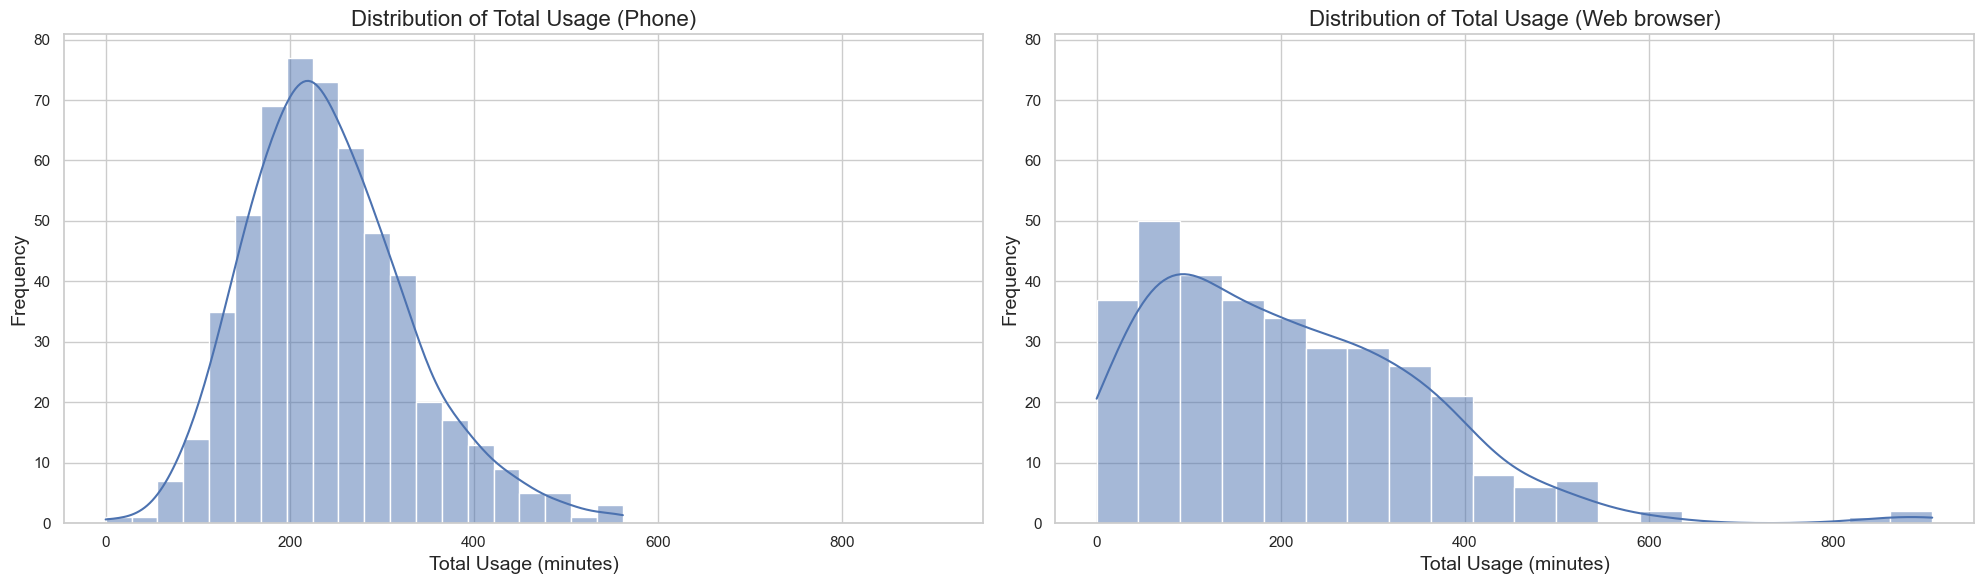

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Total usage time motorola histogram
sns.histplot(app_time_motorola['total_usage'], bins=20, kde=True, ax=axs[0])
axs[0].set_title('Distribution of Total Usage (Phone)', fontsize=16)
axs[0].set_xlabel('Total Usage (minutes)', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)

# Total usage time edge histogram
sns.histplot(web_time_edge['total_usage'], bins=20, kde=True, ax=axs[1])
axs[1].set_title('Distribution of Total Usage (Web browser)', fontsize=16)
axs[1].set_xlabel('Total Usage (minutes)', fontsize=14)
axs[1].set_ylabel('Frequency', fontsize=14)

# Get the current x and y limits
x_limits = [min(axs[0].get_xlim()[0], axs[1].get_xlim()[0]), max(axs[0].get_xlim()[1], axs[1].get_xlim()[1])]
y_limits = [min(axs[0].get_ylim()[0], axs[1].get_ylim()[0]), max(axs[0].get_ylim()[1], axs[1].get_ylim()[1])]

# Set the x and y limits to be the same for both plots
axs[0].set_xlim(x_limits)
axs[1].set_xlim(x_limits)
axs[0].set_ylim(y_limits)
axs[1].set_ylim(y_limits)

plt.tight_layout()
plt.show()

Creating a variable to store all the column names that are the applications in the dataframes

In [40]:
app_columns = app_time_motorola.columns[1:-1]
web_columns = web_time_edge.columns[1:-1]

From the following graphs it can be seen the most used applications, with boxplots taking longer space in the graphs.

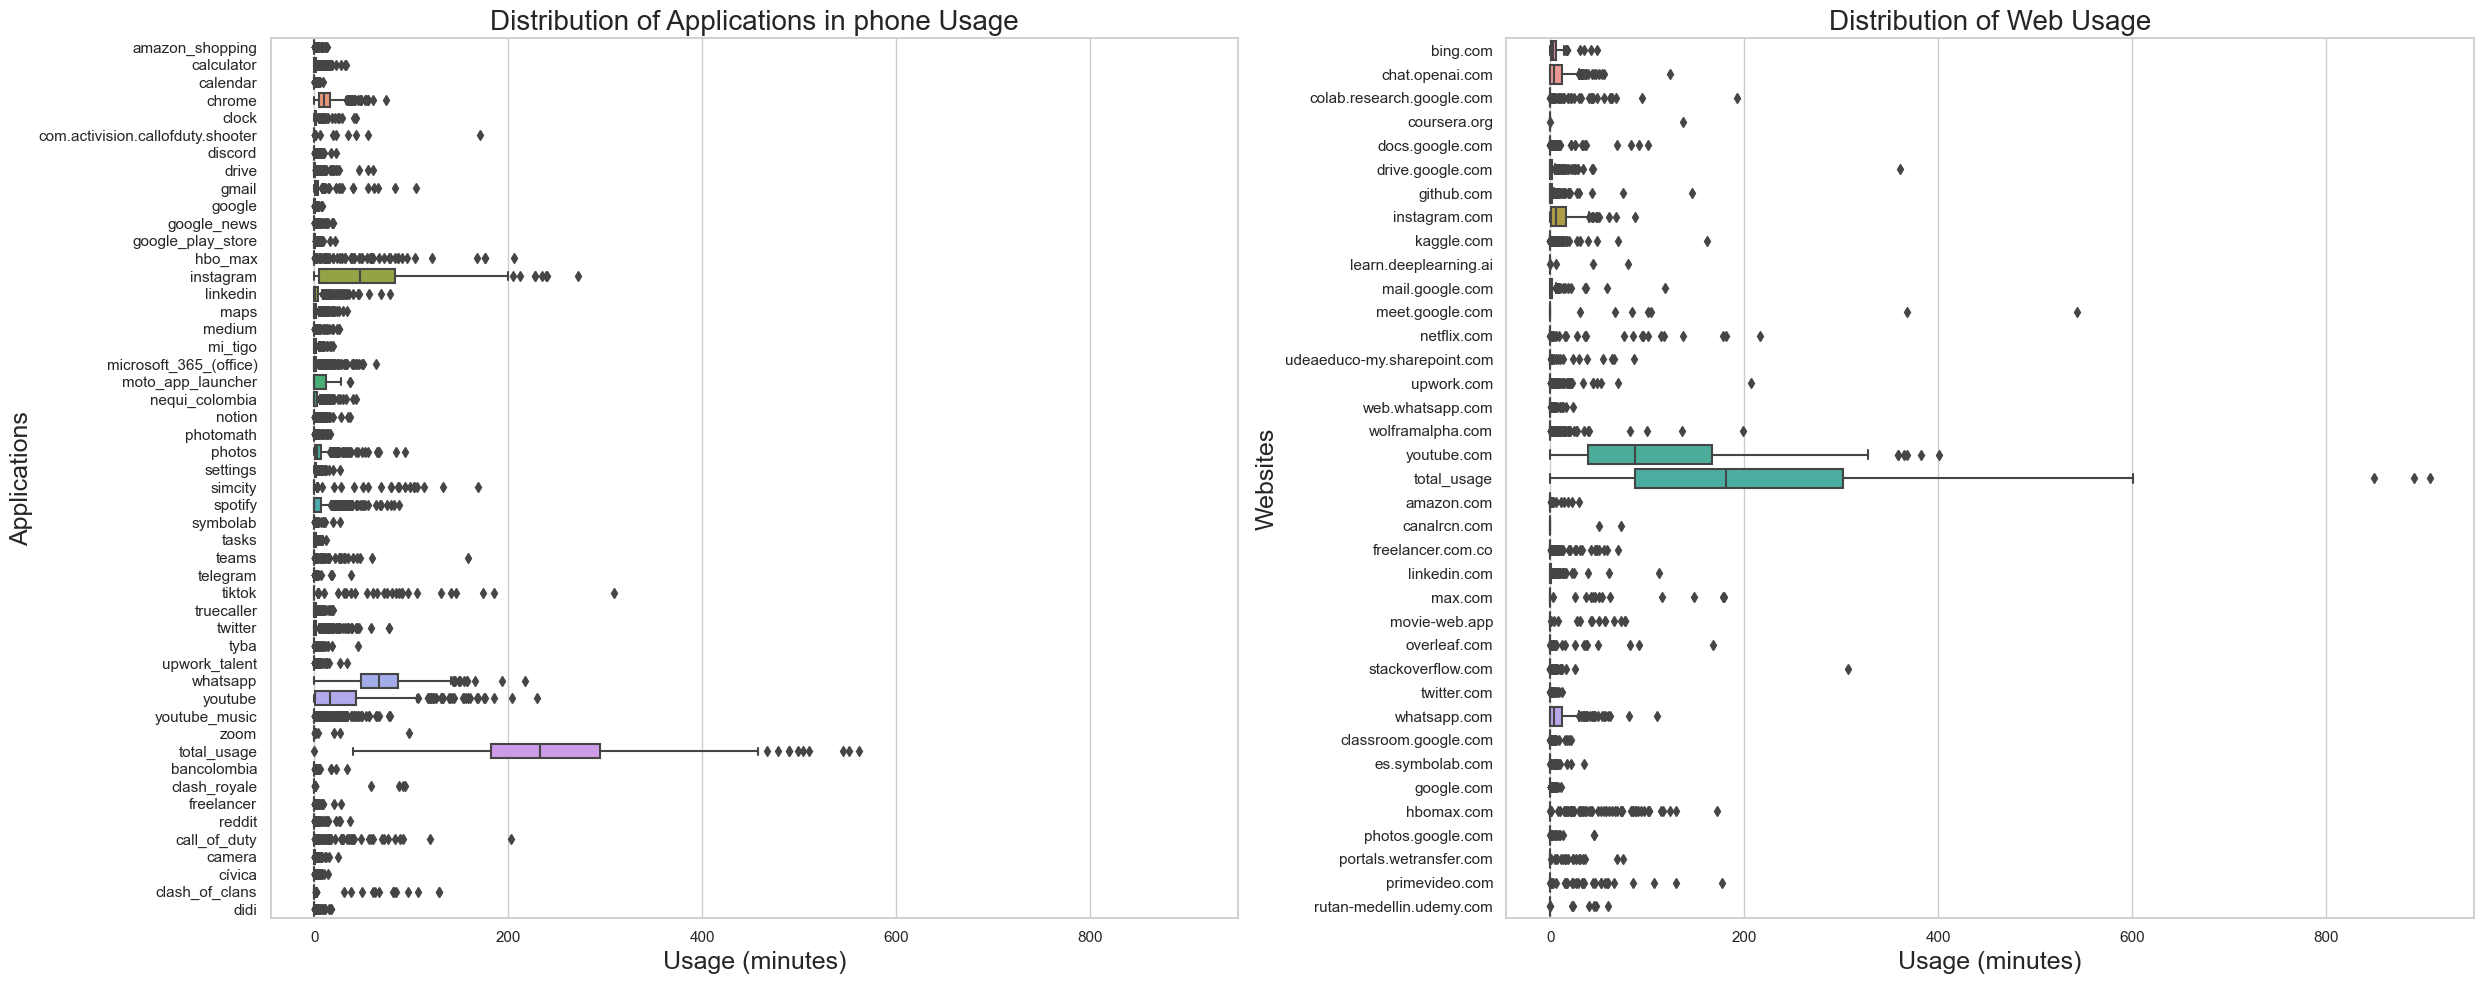

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(25, 10))

# Application usage time boxplot
sns.boxplot(data=app_time_motorola[app_columns], orient='h', ax=axs[0])
axs[0].set_title('Distribution of Applications in phone Usage', fontsize=20)
axs[0].set_xlabel('Usage (minutes)', fontsize=18)
axs[0].set_ylabel('Applications', fontsize=18)

# Web usage time boxplot
sns.boxplot(data=web_time_edge[web_columns], orient='h', ax=axs[1])
axs[1].set_title('Distribution of Web Usage', fontsize=20)
axs[1].set_xlabel('Usage (minutes)', fontsize=18)
axs[1].set_ylabel('Websites', fontsize=18)

# Get the current x limits
x_limits = [min(axs[0].get_xlim()[0], axs[1].get_xlim()[0]), max(axs[0].get_xlim()[1], axs[1].get_xlim()[1])]

# Set the x limits to be the same for both plots
axs[0].set_xlim(x_limits)
axs[1].set_xlim(x_limits)

plt.tight_layout()
plt.show()

From the following graph it can be seen the average usage of the most used applications in both phone and website.

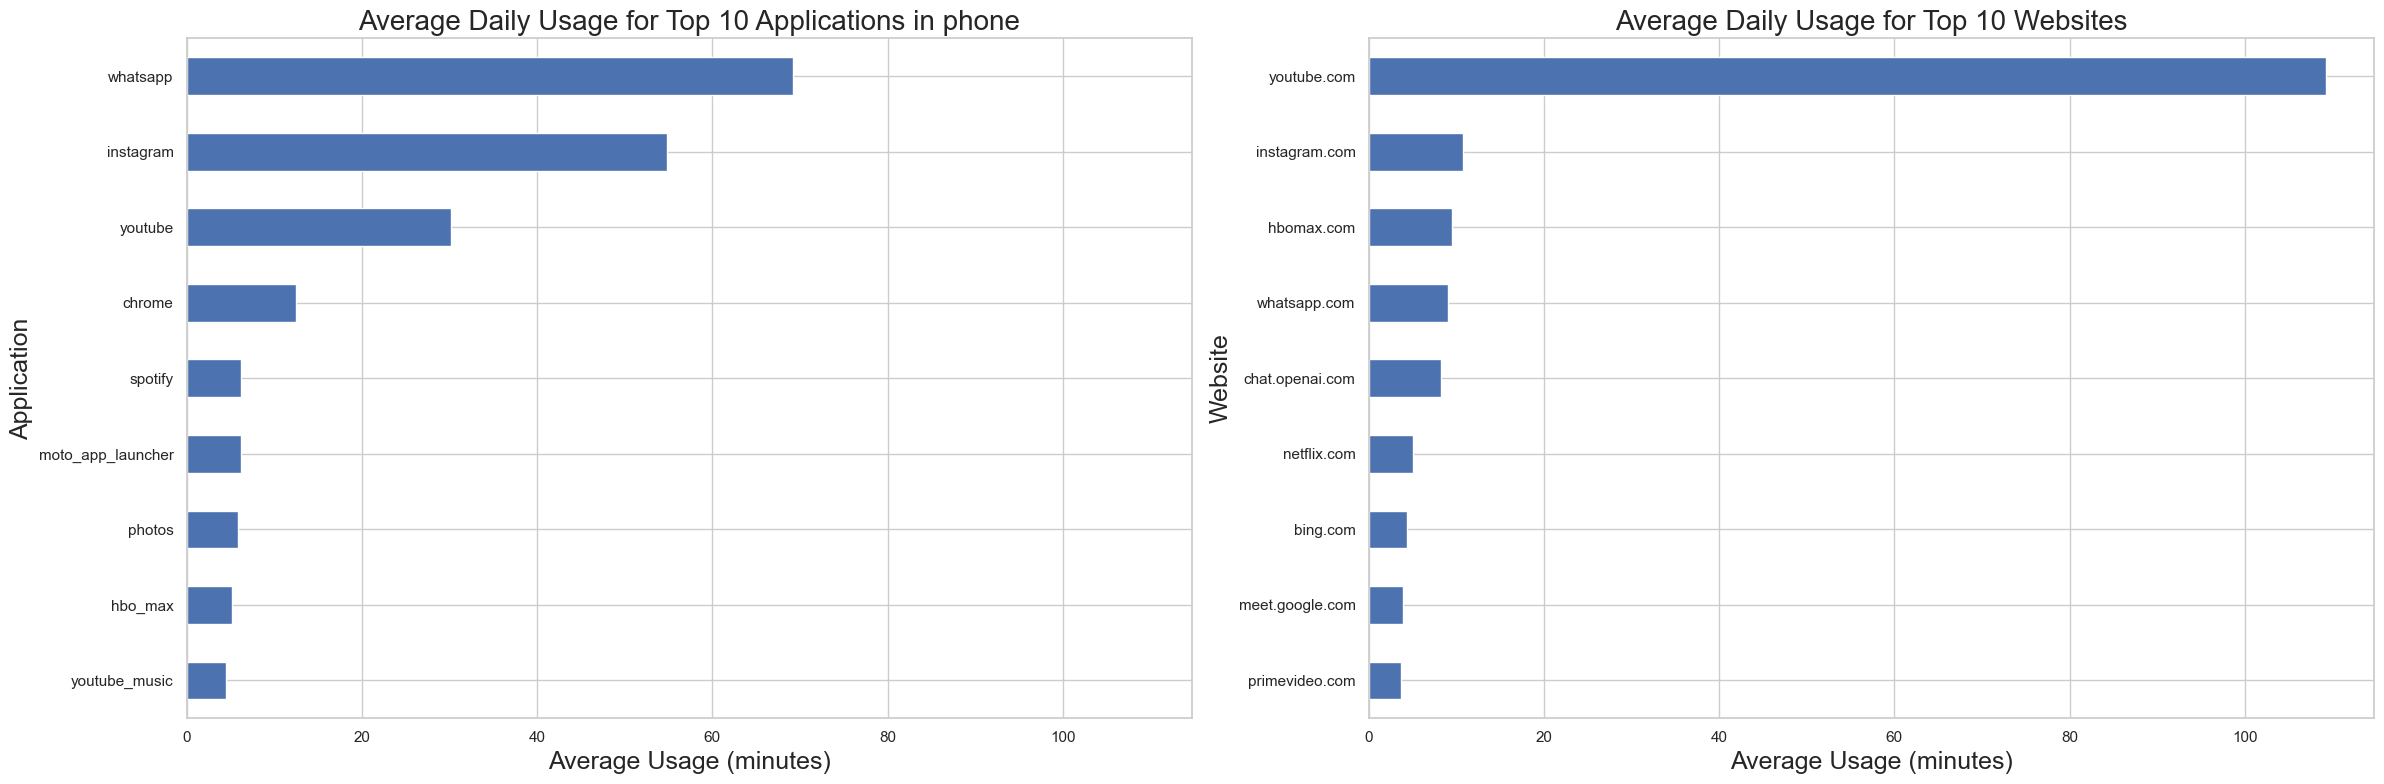

In [63]:
# Calculate average daily usage for each application and website
daily_avg_app_usage = app_time_motorola[app_columns].mean().sort_values(ascending=False)[1:10]
daily_avg_web_usage = web_time_edge[web_columns].mean().sort_values(ascending=False)[1:10]

fig, axs = plt.subplots(1, 2, figsize=(24, 8))

# Plotting average daily usage for each application
daily_avg_app_usage.sort_values().plot(kind='barh', ax=axs[0])
axs[0].set_title('Average Daily Usage for Top 10 Applications in phone', fontsize=20)
axs[0].set_xlabel('Average Usage (minutes)', fontsize=18)
axs[0].set_ylabel('Application', fontsize=18)

# Plotting average daily usage for each website
daily_avg_web_usage.sort_values().plot(kind='barh', ax=axs[1])
axs[1].set_title('Average Daily Usage for Top 10 Websites', fontsize=20)
axs[1].set_xlabel('Average Usage (minutes)', fontsize=18)
axs[1].set_ylabel('Website', fontsize=18)

# Get the current x limits
x_limits = [min(axs[0].get_xlim()[0], axs[1].get_xlim()[0]), max(axs[0].get_xlim()[1], axs[1].get_xlim()[1])]

# Set the x limits to be the same for both plots
axs[0].set_xlim(x_limits)
axs[1].set_xlim(x_limits)

plt.tight_layout()
plt.show()

From the following graph it can be concluded the following: 
- The tendency of the phone usage through the weekdays tends to mantains steady, with a slight increase in the weekend days.
- On the other hand, the website usage through the weekdays is pretty notorious that the weekend days are the most used in average.
- It is interesting to see that the mondays are the days that I used the devices the least.

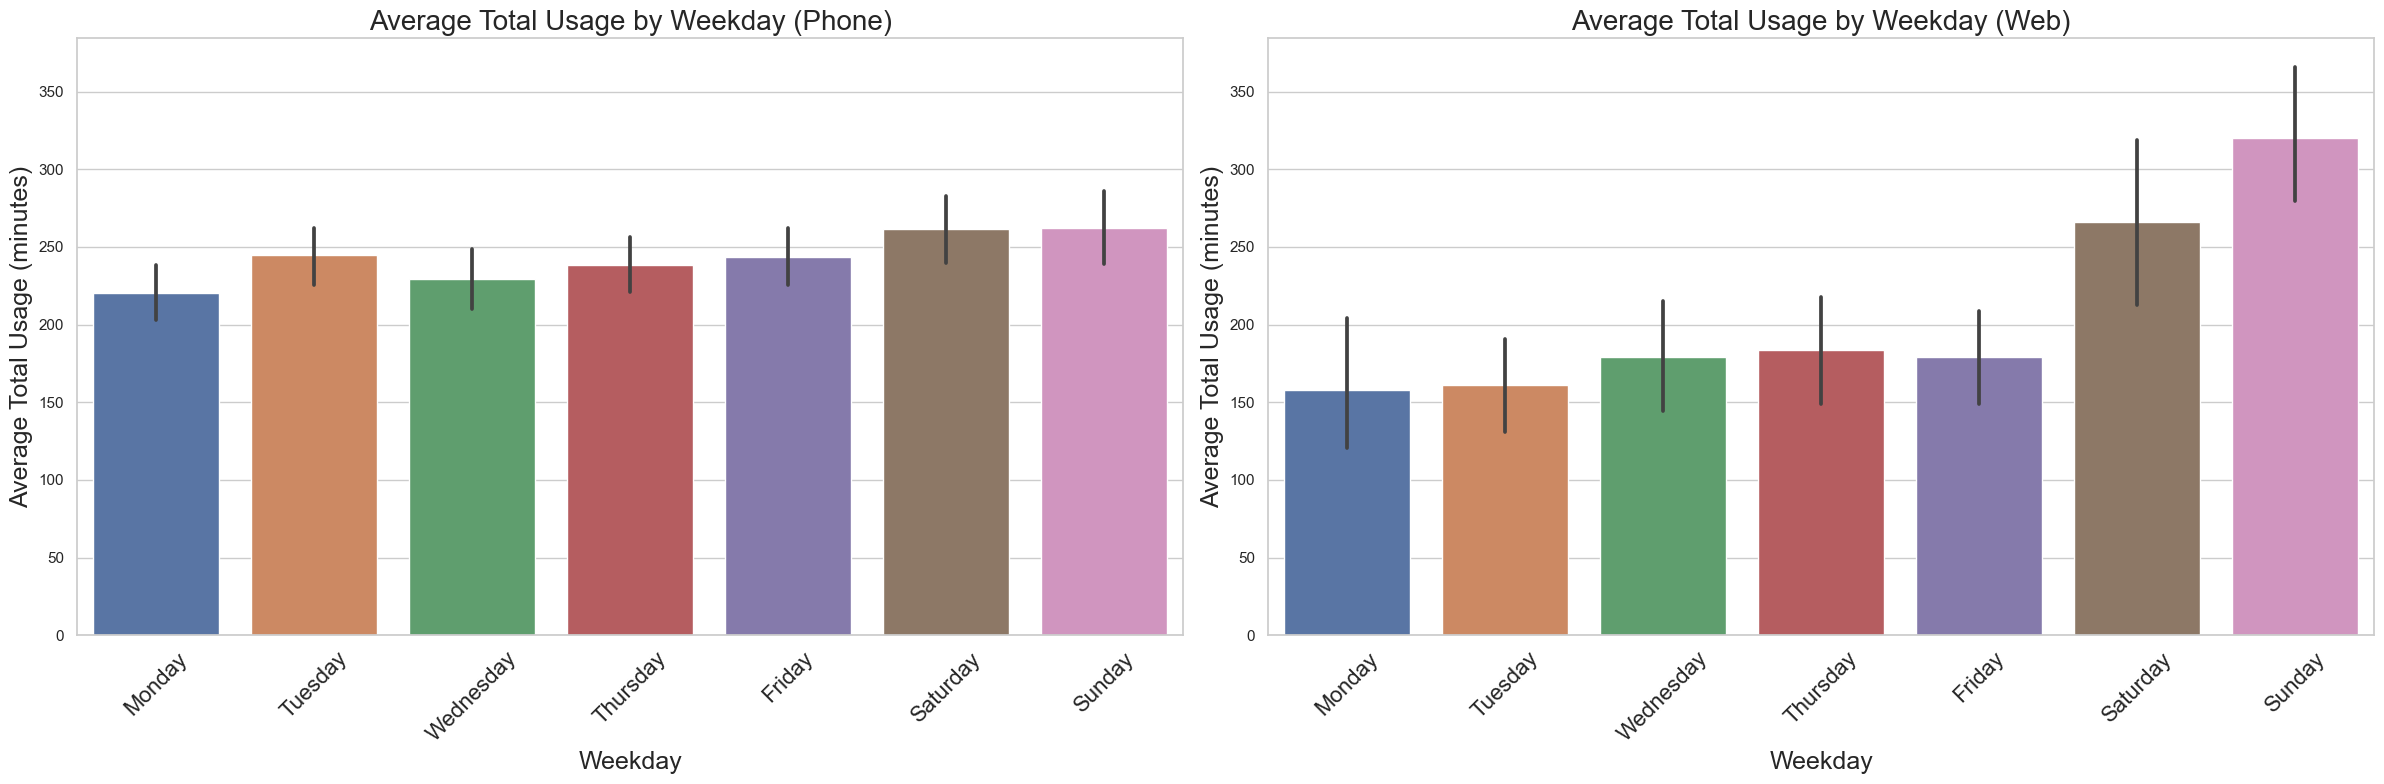

In [64]:
# Extract weekday from the date column
app_time_motorola['weekday'] = pd.to_datetime(app_time_motorola['date']).dt.weekday
web_time_edge['weekday'] = pd.to_datetime(web_time_edge['date']).dt.weekday

# Map weekday numbers to names
weekday_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
app_time_motorola['weekday_name'] = app_time_motorola['weekday'].map(weekday_names)
web_time_edge['weekday_name'] = web_time_edge['weekday'].map(weekday_names)

fig, axs = plt.subplots(1, 2, figsize=(24, 8))

# Plotting average usage by weekday for app_time_motorola
sns.barplot(x='weekday_name', y='total_usage', data=app_time_motorola, order=weekday_names.values(), ax=axs[0])
axs[0].set_title('Average Total Usage by Weekday (Phone)', fontsize=20)
axs[0].set_xlabel('Weekday', fontsize=18)
axs[0].set_ylabel('Average Total Usage (minutes)', fontsize=18)
axs[0].tick_params(axis='x', rotation=45, labelsize=16)

# Plotting average usage by weekday for web_time_edge
sns.barplot(x='weekday_name', y='total_usage', data=web_time_edge, order=weekday_names.values(), ax=axs[1])
axs[1].set_title('Average Total Usage by Weekday (Web)', fontsize=20)
axs[1].set_xlabel('Weekday', fontsize=18)
axs[1].set_ylabel('Average Total Usage (minutes)', fontsize=18)
axs[1].tick_params(axis='x', rotation=45, labelsize=16)

# Get the current y-axis limits
ymin0, ymax0 = axs[0].get_ylim()
ymin1, ymax1 = axs[1].get_ylim()

# Set the y-axis limits to the maximum range
axs[0].set_ylim(min(ymin0, ymin1), max(ymax0, ymax1))
axs[1].set_ylim(min(ymin0, ymin1), max(ymax0, ymax1))

plt.tight_layout()
plt.show()

From the following graph it can be concluded the following: 
- The graph might be a little bit biased because it has more data for the first four months of the year than the rest.
- The middle part of the year is the most used time with the phone, this could be due to the mid-year holidays from collage.
- In contrast, the middle part of the year for web usage are the less used months. 

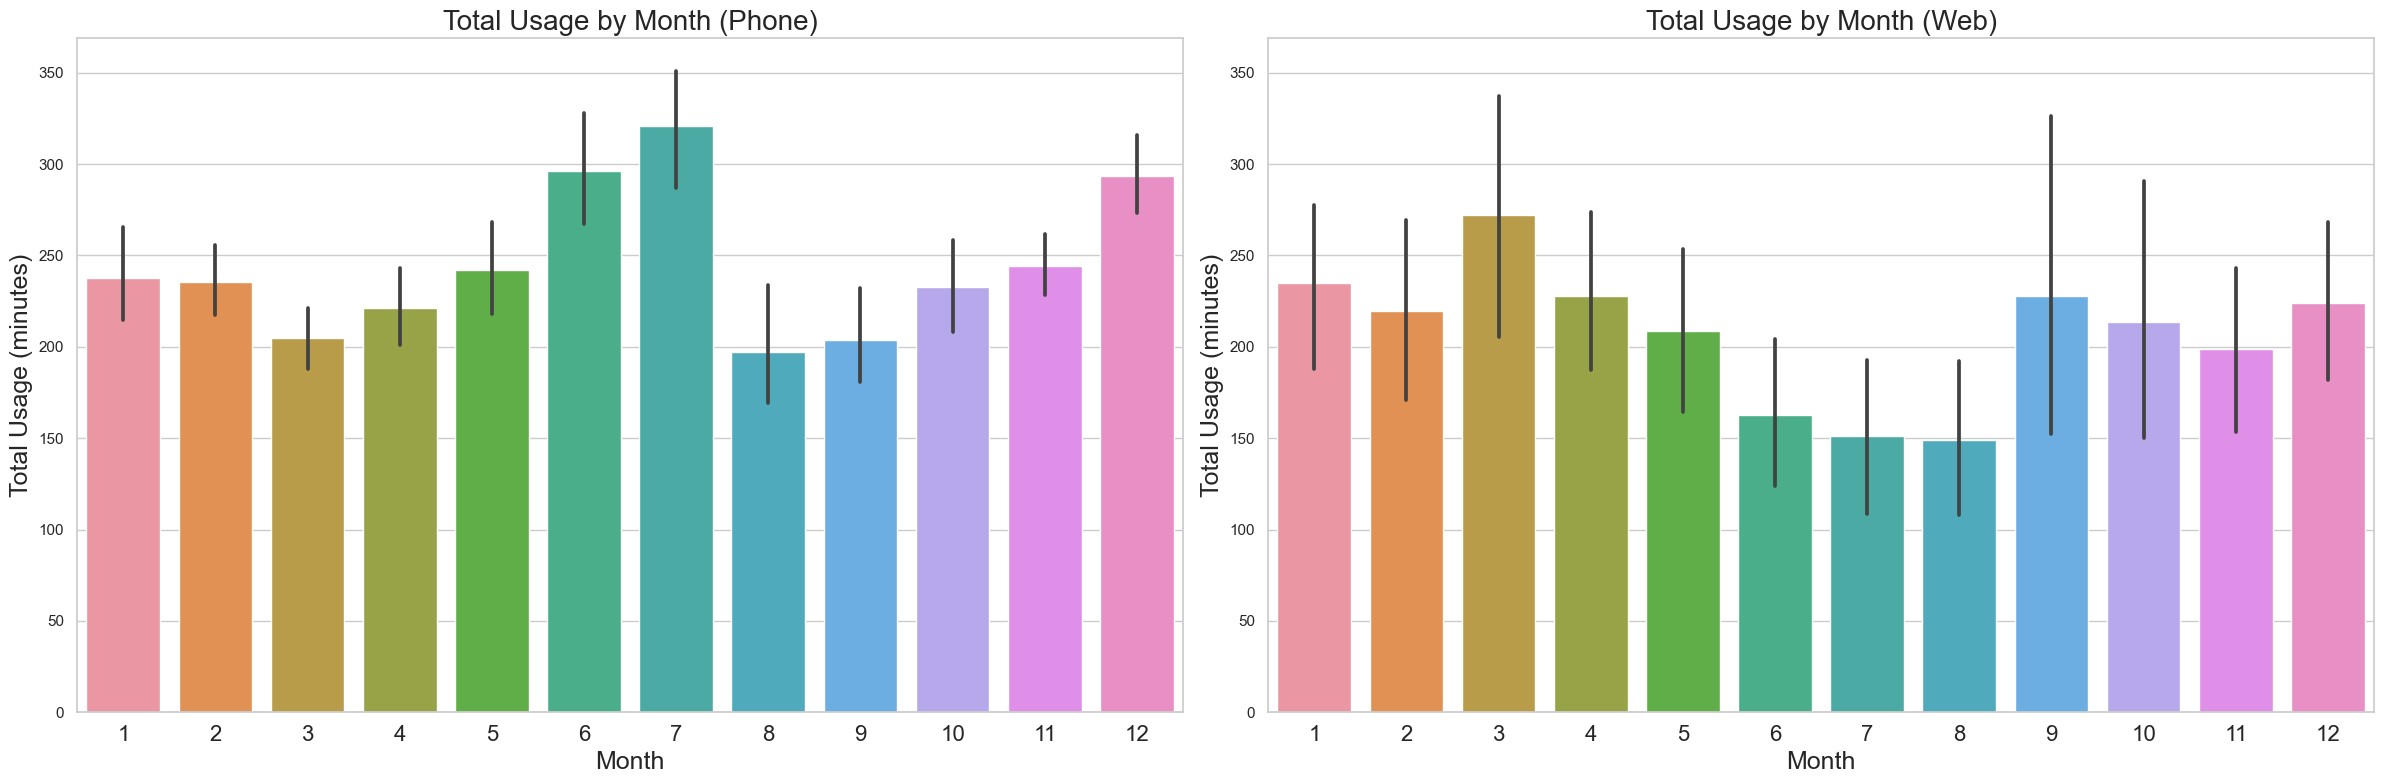

In [67]:
# Extract month from the date column
app_time_motorola['month'] = pd.to_datetime(app_time_motorola['date']).dt.month
web_time_edge['month'] = pd.to_datetime(web_time_edge['date']).dt.month

fig, axs = plt.subplots(1, 2, figsize=(24, 8))

# Plotting total usage by month for app_time_motorola
sns.barplot(x='month', y='total_usage', data=app_time_motorola, ax=axs[0])
axs[0].set_title('Total Usage by Month (Phone)', fontsize=20)
axs[0].set_xlabel('Month', fontsize=18)
axs[0].set_ylabel('Total Usage (minutes)', fontsize=18)
axs[0].set_xticks(range(0, 12))
axs[0].tick_params(axis='x', labelsize=16)

# Plotting total usage by month for web_time_edge
sns.barplot(x='month', y='total_usage', data=web_time_edge, ax=axs[1])
axs[1].set_title('Total Usage by Month (Web)', fontsize=20)
axs[1].set_xlabel('Month', fontsize=18)
axs[1].set_ylabel('Total Usage (minutes)', fontsize=18)
axs[1].set_xticks(range(0, 12))
axs[1].tick_params(axis='x', labelsize=16)

# Get the current y-axis limits
ymin0, ymax0 = axs[0].get_ylim()
ymin1, ymax1 = axs[1].get_ylim()

# Set the y-axis limits to the maximum range
axs[0].set_ylim(min(ymin0, ymin1), max(ymax0, ymax1))
axs[1].set_ylim(min(ymin0, ymin1), max(ymax0, ymax1))

plt.tight_layout()
plt.show()